### Python Environment Preparation

##### Install python based spark:
* !pip install pyspark

The folowing commands imported the packages we need to use for the purpose of analysis of this project and connected to SparkSQL.

In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [1]:
import os
os.environ['SPARK_HOME'] = '/usr/local/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext
spark = SparkContext(appName='yelp-proj')
spark

<SparkContext master=local[*] appName=yelp-proj>

### Read json data using Spark and prepare tables for SparkSQL

The commands below imported the data in the json files and created corresponding tables for future analysis using SQL.

In [2]:
from pyspark import SQLContext
sqlc = SQLContext(spark)
business = sqlc.read.json("business.json")
checkin = sqlc.read.json("checkin.json")
photos = sqlc.read.json("photos.json")
review = sqlc.read.json("review.json")
tip = sqlc.read.json("tip.json")
user = sqlc.read.json("user.json")

In [3]:
business.createOrReplaceTempView("business")
checkin.createOrReplaceTempView("checkin")
photos.createOrReplaceTempView("photos")
review.createOrReplaceTempView("review")
tip.createOrReplaceTempView("tip")
user.createOrReplaceTempView("user")

### look into json data

Let's take a look at the number of rows and the attributes of the six tables.

In [5]:
print (business.count())
print (checkin.count())
print (photos.count())
print (review.count())
print (tip.count())
print (user.count())

156639
135148
196278
4736897
1028802
1183362


In [5]:
business.columns

['address',
 'attributes',
 'business_id',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'neighborhood',
 'postal_code',
 'review_count',
 'stars',
 'state']

In [21]:
checkin.columns

['business_id', 'time']

In [24]:
photos.columns

['business_id', 'caption', 'label', 'photo_id']

In [26]:
review.columns

['business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id']

In [27]:
tip.columns

['business_id', 'date', 'likes', 'text', 'user_id']

In [28]:
user.columns

['average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite',
 'fans',
 'friends',
 'funny',
 'name',
 'review_count',
 'useful',
 'user_id',
 'yelping_since']

#### a data sample

In [128]:
!cat business.json | shuf -n 1 > example.json
import json
print(json.dumps(json.load(open("example.json")), indent=8))

{
        "hours": {
                "Tuesday": "5:00-23:00",
                "Monday": "5:00-23:00",
                "Wednesday": "5:00-23:00",
                "Sunday": "7:00-20:00",
                "Friday": "5:00-21:00",
                "Saturday": "7:00-20:00",
                "Thursday": "5:00-23:00"
        },
        "city": "Madison",
        "stars": 3.5,
        "postal_code": "53703",
        "address": "44 E Mifflin St",
        "attributes": {
                "GoodForKids": false
        },
        "categories": [
                "Active Life",
                "Gyms",
                "Fitness & Instruction"
        ],
        "review_count": 7,
        "business_id": "_YUy0KbTv9hPtmvJwvQrPw",
        "state": "WI",
        "latitude": 43.0763819,
        "is_open": 1,
        "name": "Pinnacle Health & Fitness",
        "longitude": -89.3845861,
        "neighborhood": "Capitol"
}


### data exploration

The total stars and average count of stars in different states from the business table:

In [132]:
queries='''
SELECT state,count(stars),avg(stars)
FROM business
GROUP BY state
ORDER BY count(stars) DESC
LIMIT 10
'''
sqlc.sql(queries).show(10)

+-----+------------+------------------+
|state|count(stars)|        avg(stars)|
+-----+------------+------------------+
|   AZ|       47376|3.7277946639648767|
|   NV|       30571|3.7129632658401754|
|   ON|       26520|3.4455128205128207|
|   NC|       11299| 3.582131162049739|
|   OH|       10930|3.5740622140896616|
|   PA|        8916|  3.63021534320323|
|   QC|        7273| 3.682730647600715|
|   WI|        4190| 3.660381861575179|
|  EDH|        3561| 3.800477393990452|
|   BW|        3071|3.8069032888309997|
+-----+------------+------------------+



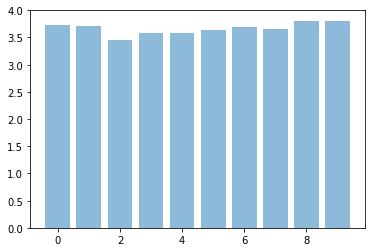

In [134]:
whichcolumn=3
x=sqlc.sql(queries).take(10)
y=[]
for n in range(len(x)):
    y.append(x[n][whichcolumn-1])
from matplotlib import pyplot as plt
plt.bar(range(len(x)),y,alpha=0.5)
plt.show()

The average count of stars in the review table associated with positive reviews:

In [13]:
queries='''
SELECT avg(stars)
FROM review
WHERE LOWER(text) LIKE "% good %"
LIMIT 10
'''
sqlc.sql(queries).show(1)

+-----------------+
|       avg(stars)|
+-----------------+
|3.701572957959402|
+-----------------+



The average count of stars in the review table associated with negative reviews:

In [14]:
queries='''
SELECT avg(stars)
FROM review
WHERE LOWER(text) LIKE "% bad %"
LIMIT 10
'''
sqlc.sql(queries).show(1)

+------------------+
|        avg(stars)|
+------------------+
|2.9274045207133534|
+------------------+



The average count of stars in the review table group by the rate of cool label:

In [24]:
queries='''
SELECT cool,avg(stars)
FROM review
WHERE cool <= 5
GROUP BY cool
ORDER BY avg(stars) DESC
LIMIT 10
'''
sqlc.sql(queries).show()

+----+------------------+
|cool|        avg(stars)|
+----+------------------+
|   5| 3.983008702859511|
|   4|3.9694766730307927|
|   3|3.9560311284046694|
|   2|3.9324638113140424|
|   1|3.8757949007698285|
|   0|3.6668892551573724|
+----+------------------+



The average count of stars in the review table group by the rate of funny label:

In [25]:
queries='''
SELECT funny,avg(stars)
FROM review
WHERE funny <= 5
GROUP BY funny
ORDER BY avg(stars) DESC
LIMIT 10
'''
sqlc.sql(queries).show()

+-----+------------------+
|funny|        avg(stars)|
+-----+------------------+
|    0|3.7995857292072075|
|    1| 3.427508838155226|
|    5|3.4109621943603785|
|    4|3.3468015403184093|
|    3| 3.288571091236459|
|    2|3.2776098179232744|
+-----+------------------+



### records we need

Combining all three tables we need together, there are 4,736,897 records.

In [54]:
queries='''
SELECT COUNT(business.categories) AS number
FROM review
LEFT OUTER JOIN business
ON review.business_id=business.business_id
LEFT OUTER JOIN user
ON review.user_id=user.user_id
'''
sqlc.sql(queries).show()

+-------+
| number|
+-------+
|4736897|
+-------+



That amount of records would be too large for this project, therefore, we limited our target to Chinese restaurants with a price range lower than $60. There are still 175,532 records after the narrow-down which is still large and sufficient.

In [22]:
queries='''
SELECT COUNT(concat_ws("-",business.categories)) AS number
FROM review
LEFT OUTER JOIN business
ON review.business_id=business.business_id
LEFT OUTER JOIN user
ON review.user_id=user.user_id
WHERE concat_ws("-",business.categories) LIKE "%Restaurant%"
AND concat_ws("-",business.categories) LIKE "%Chinese%"
AND business.attributes.RestaurantsPriceRange2 < 4
'''
sqlc.sql(queries).show()

+------+
|number|
+------+
|175532|
+------+



### Above are test codes of data preparation

Now, let's take a look at the schema of the three datasets we choose to analyze.

In [14]:
business.printSchema()
user.printSchema()
review.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: boolean (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: struct (nullable = true)
 |    |    |-- casual: boolean (nullable = true)
 |    |    |-- classy: boolean (nullable = true)
 |    |    |-- divey: boolean (nullable = true)
 |    |    |-- hipster: boolean (nullable = true)
 |    |    |-- intimate: boolean (nullable = true)
 |    |    |-- romantic: boolean (nullable = true)
 |    |    |-- touristy: boolean (nullable = true)
 |    |    |-- trendy: boolean (nullable = true)
 |    |    |-- upscale: boolean (nullable = true)
 |    |-- BYOB: boolean (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: struct (nullable = true)
 |    |    |-- friday: boolean (nullable = true)
 |    |    |-- monday: boolean (nullable = true)
 |    |    |-- saturday: boolean (nullab

To make use of all the attributes that we believe are influential, we need to do some data wrangling:

In [43]:
queries='''
SELECT 
(CASE 
WHEN business.attributes.Alcohol = "none" THEN 0
WHEN business.attributes.Alcohol IS NULL THEN 0
ELSE 1
END) alcohol
FROM review
LEFT OUTER JOIN business
ON review.business_id=business.business_id
LEFT OUTER JOIN user
ON review.user_id=user.user_id
WHERE concat_ws("-",business.categories) LIKE "%Restaurant%"
AND concat_ws("-",business.categories) LIKE "%Chinese%"
AND business.attributes.RestaurantsPriceRange2 < 4
LIMIT 10
'''
sqlc.sql(queries).show()

+-------+
|alcohol|
+-------+
|      1|
|      1|
|      1|
|      1|
|      0|
|      1|
|      0|
|      0|
|      0|
|      1|
+-------+



In [36]:
queries='''
SELECT DISTINCT business.attributes.NoiseLevel
FROM review
LEFT OUTER JOIN business
ON review.business_id=business.business_id
LEFT OUTER JOIN user
ON review.user_id=user.user_id
WHERE concat_ws("-",business.categories) LIKE "%Restaurant%"
AND concat_ws("-",business.categories) LIKE "%Chinese%"
AND business.attributes.RestaurantsPriceRange2 < 4
LIMIT 10
'''
sqlc.sql(queries).show()

+----------+
|NoiseLevel|
+----------+
|      null|
|   average|
|      loud|
|     quiet|
| very_loud|
+----------+



In [45]:
queries='''
SELECT 
CASE WHEN business.attributes.NoiseLevel = "quiet" THEN 0
WHEN business.attributes.NoiseLevel = "average" THEN 1
WHEN business.attributes.NoiseLevel = "loud" THEN 2
WHEN business.attributes.NoiseLevel = "very_loud" THEN 3
ELSE 1 END noiselevel
FROM review
LEFT OUTER JOIN business
ON review.business_id=business.business_id
LEFT OUTER JOIN user
ON review.user_id=user.user_id
WHERE concat_ws("-",business.categories) LIKE "%Restaurant%"
AND concat_ws("-",business.categories) LIKE "%Chinese%"
AND business.attributes.RestaurantsPriceRange2 < 4
LIMIT 10
'''
sqlc.sql(queries).show()

+----------+
|noiselevel|
+----------+
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         0|
|         0|
|         1|
|         1|
+----------+



In [53]:
queries='''
SELECT 
CASE 
WHEN business.attributes.BusinessParking.lot 
OR business.attributes.BusinessParking.garage
OR business.attributes.BusinessParking.street = "true" THEN 1
ELSE 0 END businessparking
FROM review
LEFT OUTER JOIN business
ON review.business_id=business.business_id
LEFT OUTER JOIN user
ON review.user_id=user.user_id
WHERE concat_ws("-",business.categories) LIKE "%Restaurant%"
AND concat_ws("-",business.categories) LIKE "%Chinese%"
AND business.attributes.RestaurantsPriceRange2 < 4
LIMIT 10
'''
sqlc.sql(queries).show()

+---------------+
|businessparking|
+---------------+
|              1|
|              1|
|              1|
|              1|
|              1|
|              1|
|              0|
|              1|
|              1|
|              1|
+---------------+



In [56]:
queries='''
SELECT DISTINCT business.attributes.Smoking
FROM review
LEFT OUTER JOIN business
ON review.business_id=business.business_id
LEFT OUTER JOIN user
ON review.user_id=user.user_id
WHERE concat_ws("-",business.categories) LIKE "%Restaurant%"
AND concat_ws("-",business.categories) LIKE "%Chinese%"
AND business.attributes.RestaurantsPriceRange2 < 4
LIMIT 10
'''
sqlc.sql(queries).show()

+-------+
|Smoking|
+-------+
|   null|
|     no|
|    yes|
|outdoor|
+-------+



In [58]:
queries='''
SELECT 
CASE 
WHEN business.attributes.Smoking = "no" THEN 0
ELSE 1 END smoking
FROM review
LEFT OUTER JOIN business
ON review.business_id=business.business_id
LEFT OUTER JOIN user
ON review.user_id=user.user_id
WHERE concat_ws("-",business.categories) LIKE "%Restaurant%"
AND concat_ws("-",business.categories) LIKE "%Chinese%"
AND business.attributes.RestaurantsPriceRange2 < 4
LIMIT 10
'''
sqlc.sql(queries).show()

+-------+
|smoking|
+-------+
|      1|
|      1|
|      1|
|      1|
|      1|
|      1|
|      1|
|      1|
|      1|
|      1|
+-------+



In [60]:
queries='''
SELECT 
CASE business.attributes.WIFI
WHEN "free" THEN 1
ELSE 0 END wifi
FROM review
LEFT OUTER JOIN business
ON review.business_id=business.business_id
LEFT OUTER JOIN user
ON review.user_id=user.user_id
WHERE concat_ws("-",business.categories) LIKE "%Restaurant%"
AND concat_ws("-",business.categories) LIKE "%Chinese%"
AND business.attributes.RestaurantsPriceRange2 < 4
LIMIT 10
'''
sqlc.sql(queries).show()

+----+
|wifi|
+----+
|   0|
|   0|
|   0|
|   0|
|   0|
|   1|
|   0|
|   1|
|   0|
|   0|
+----+



In [ ]:
queries='''
    SELECT user.average_stars, user.review_count, user.fans, DATEDIFF('2017-12-03', user.yelping_since) as yelping_since_day
    FROM review
    LEFT OUTER JOIN business
    ON review.business_id=business.business_id
    LEFT OUTER JOIN user
    ON review.user_id=user.user_id
    WHERE concat_ws("-",business.categories) LIKE "%Restaurant%"
    AND concat_ws("-",business.categories) LIKE "%Chinese%"
    AND business.attributes.RestaurantsPriceRange2 < 4
    LIMIT 10
'''
sqlc.sql(queries).show()

We set the different categories of some of the attributes in our tables to 1 and 0 according to our purpose of analysis and in this way, the null values were also settled. Now, the data are ready and prepared for building the model by joing them all together.

##### test

In [6]:
queries='''
SELECT
CASE WHEN business.attributes.Smoking = "no" THEN 0 ELSE 1 END smoking,
CASE business.attributes.WIFI WHEN "free" THEN 1 ELSE 0 END wifi,
CASE WHEN business.attributes.BusinessParking.lot OR business.attributes.BusinessParking.garage
            OR business.attributes.BusinessParking.street = "true" THEN 1 ELSE 0 END parking,
CASE WHEN business.attributes.NoiseLevel = "quiet" THEN 0
     WHEN business.attributes.NoiseLevel = "average" THEN 1
     WHEN business.attributes.NoiseLevel = "loud" THEN 2
     WHEN business.attributes.NoiseLevel = "very_loud" THEN 3
     ELSE 1 END noiselevel,
CASE WHEN business.attributes.Alcohol = "none" THEN 0
     WHEN business.attributes.Alcohol IS NULL THEN 0
     ELSE 1 END alcohol,
CASE WHEN business.attributes.BusinessAcceptsCreditCards = "false" THEN 0
     WHEN business.attributes.BusinessAcceptsCreditCards = "true" THEN 1
     ELSE 0 END creditcards,
CASE WHEN business.attributes.RestaurantsDelivery = "false" THEN 0
     WHEN business.attributes.RestaurantsDelivery = "true" THEN 1
     ELSE 0 END deliery,
CASE WHEN business.attributes.RestaurantsGoodForGroups = "false" THEN 0
     WHEN business.attributes.RestaurantsGoodForGroups = "true" THEN 1
     ELSE 0 END goodforgroups,
CASE WHEN business.attributes.RestaurantsReservations = "false" THEN 0
     WHEN business.attributes.RestaurantsReservations = "true" THEN 1
     ELSE 0 END reservations,
business.review_count,business.stars,
user.average_stars, user.review_count, user.fans, DATEDIFF('2017-12-03', user.yelping_since) as yelping_since_day,
review.stars
FROM review
LEFT OUTER JOIN business
ON review.business_id=business.business_id
LEFT OUTER JOIN user
ON review.user_id=user.user_id
WHERE concat_ws("-",business.categories) LIKE "%Restaurant%"
AND concat_ws("-",business.categories) LIKE "%Chinese%"
AND business.attributes.RestaurantsPriceRange2 < 4
LIMIT 5
'''
sqlc.sql(queries).show()

+-------+----+-------+----------+-------+-----------+-------+-------------+------------+------------+-----+-------------+------------+----+-----------------+-----+
|smoking|wifi|parking|noiselevel|alcohol|creditcards|deliery|goodforgroups|reservations|review_count|stars|average_stars|review_count|fans|yelping_since_day|stars|
+-------+----+-------+----------+-------+-----------+-------+-------------+------------+------------+-----+-------------+------------+----+-----------------+-----+
|      1|   0|      1|         1|      1|          0|      0|            1|           0|         170|  4.0|          4.5|           8|   0|              915|    5|
|      1|   0|      1|         1|      1|          1|      0|            1|           0|         104|  4.0|          4.5|           8|   0|              915|    5|
|      1|   0|      1|         1|      1|          1|      0|            1|           0|         207|  2.5|          3.0|           2|   0|             1067|    1|
|      1|   0|  

##### get fit data for model

In [6]:
queries='''
SELECT
CASE WHEN business.attributes.Smoking = "no" THEN 0 ELSE 1 END smoking,
CASE business.attributes.WIFI WHEN "free" THEN 1 ELSE 0 END wifi,
CASE WHEN business.attributes.BusinessParking.lot OR business.attributes.BusinessParking.garage
            OR business.attributes.BusinessParking.street = "true" THEN 1 ELSE 0 END parking,
CASE WHEN business.attributes.NoiseLevel = "quiet" THEN 0
     WHEN business.attributes.NoiseLevel = "average" THEN 1
     WHEN business.attributes.NoiseLevel = "loud" THEN 2
     WHEN business.attributes.NoiseLevel = "very_loud" THEN 3
     ELSE 1 END noiselevel,
CASE WHEN business.attributes.Alcohol = "none" THEN 0
     WHEN business.attributes.Alcohol IS NULL THEN 0
     ELSE 1 END alcohol,
CASE WHEN business.attributes.BusinessAcceptsCreditCards = "false" THEN 0
     WHEN business.attributes.BusinessAcceptsCreditCards = "true" THEN 1
     ELSE 0 END creditcards,
CASE WHEN business.attributes.RestaurantsDelivery = "false" THEN 0
     WHEN business.attributes.RestaurantsDelivery = "true" THEN 1
     ELSE 0 END deliery,
CASE WHEN business.attributes.RestaurantsGoodForGroups = "false" THEN 0
     WHEN business.attributes.RestaurantsGoodForGroups = "true" THEN 1
     ELSE 0 END goodforgroups,
CASE WHEN business.attributes.RestaurantsReservations = "false" THEN 0
     WHEN business.attributes.RestaurantsReservations = "true" THEN 1
     ELSE 0 END reservations,
business.review_count AS breviewcount,business.stars AS businessstars,
user.average_stars, user.review_count AS userreviewcount, user.fans,
DATEDIFF('2017-12-03', user.yelping_since) as yelping_since_day,
review.stars AS reviewstars
FROM review
LEFT OUTER JOIN business
ON review.business_id=business.business_id
LEFT OUTER JOIN user
ON review.user_id=user.user_id
WHERE concat_ws("-",business.categories) LIKE "%Restaurant%"
AND concat_ws("-",business.categories) LIKE "%Chinese%"
AND business.attributes.RestaurantsPriceRange2 < 4
'''
mytable=sqlc.sql(queries)

##### check our data and store in csv

In [7]:
mytable.count()

175532

In [8]:
mynew=mytable.toPandas()
mynew.to_csv("yelpdata.csv",index=False,header=True)

### fit model
* linear regression
* logistic regression
* decision tree

In [124]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(mynew.iloc[:,0:15],mynew["reviewstars"],test_size = 0.2)
linreg=linear_model.LinearRegression()
linreg.fit(x_train,y_train)
print("Linear Regression")
print('Variance score-test: %.2f' % linreg.score(x_train, y_train))
print('Variance score-train: %.2f' % linreg.score(x_test, y_test))

Linear Regression
Variance score-test: 0.35
Variance score-train: 0.35


In [116]:
linreg.predict(mynew.iloc[0:5,0:15])

array([ 4.64554054,  4.59885087,  2.23246137,  3.60706794,  2.8129557 ])

In [123]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(mynew.iloc[:,0:15],mynew["reviewstars"],test_size = 0.2)
logreg=LogisticRegression()sed
logreg.fit(x_train,y_train)
print("Logistic Regression")
print('Variance score-test: %.2f' % logreg.score(x_train, y_train))
print('Variance score-train: %.2f' % logreg.score(x_test, y_test))

Logistic Regression
Variance score-test: 0.43
Variance score-train: 0.43


In [117]:
logreg.predict(mynew.iloc[0:5,0:15])

array([5, 5, 1, 4, 4])

In [122]:
from sklearn import tree
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(mynew.iloc[:,0:15],mynew["reviewstars"],test_size = 0.2)
dstree = tree.DecisionTreeClassifier(splitter="best",max_depth=10,min_samples_split=25,min_samples_leaf=10)
dstree.fit(x_train,y_train)
print("Decision Tree")
print('Variance score-test: %.2f' % dstree.score(x_train, y_train))
print('Variance score-train: %.2f' % dstree.score(x_test, y_test))

Decision Tree
Variance score-test: 0.48
Variance score-train: 0.46


In [114]:
dstree.predict(mynew.iloc[0:5,0:15])

array([5, 5, 1, 4, 3])

##### Decision Tree Plot

In [126]:
import graphviz 
treeplot = tree.export_graphviz(mytree, out_file=None) 
graph = graphviz.Source(treeplot) 
graph